# Notebook for generating the images for the report

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from architecture.Model import Model
from dataloader.Dataloader import *
from torchvision.utils import make_grid, save_image
from torchvision.transforms.functional import resize
from munch import Munch

In [2]:
def tensor_to_imgs(tensor):
    X = torch.permute(tensor, [0,2,3,1]).cpu().detach().numpy()
    x_n = [(x-x.min())/(x.max()-x.min()) for x in X]
    imgs = [img for img in x_n]
    return imgs

In [3]:
def generate_figure(ref_imgs, src_imgs, fake_imgs_list):
    plt.figure(figsize=(15,2), dpi=400)
    plt.subplot(1,len(src_imgs)+1,1)
    plt.imshow(np.ones(ref_imgs[0].shape))
    plt.axis('off')
    plt.suptitle("Source Images")
    for i, src_img in enumerate(src_imgs):
        plt.subplot(1,len(src_imgs)+1,i+2)
        plt.imshow(src_img)
        plt.axis('off')
    plt.show()
    
    for i,(ref_img, fake_imgs) in enumerate(zip(ref_imgs, fake_imgs_list)):
        plt.figure(figsize=(15,3), dpi=400)
        plt.subplot(1,len(fake_imgs)+1,1)
        plt.imshow(ref_img)
        plt.axis('off')
        if i == 0 :
            plt.title("Reference Image")
        #plt.suptitle("Generated Images")
        for i, fake_img in enumerate(fake_imgs):
            plt.subplot(1,len(fake_imgs)+1,i+2)
            plt.imshow(fake_img)
            plt.axis('off')
        plt.show()

## CELEBA_HQ
Vizualisation of reference and latent guided generated images

In [3]:
#import celeba pretrained model
model_params = Munch({
    'img_size': 256, #256
    'latent_dim': 16,
    'style_dim': 64,
    'num_domains' : 2, #celeba
    'fan_pretrained_fname' : "architecture/FAN/weights.pth",
    "wFilter" : 1 # 0<= -> no FAN
})

nets, _ = Model(model_params) #instantiate model
cpt = torch.load("runs/celeba_model/000010__networs_copy.cpt") #take the copy weights -> moving average improves quality

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model_name, model in nets.items():
    print(model_name)
    if model_name in cpt:
        model.load_state_dict(cpt[model_name])
        model.eval().to(device)

generator
mapping_network
style_encoder
discriminator
fan


In [4]:
#load male and female datasets
root = "../shared/stargan_folder/data/celeba_hq/val"
batch_size=6

#contains both male and female imgs. Returns corresponding label.
test_loader = get_loader(root, batch_size, model_params.img_size, chunk="test")
test_fetcher = Fetcher(test_loader,chunk="test")

male_path=os.path.join(root,"male")
male_loader = get_loader(male_path, batch_size//2, model_params.img_size, chunk="eval")
male_fetcher = Fetcher(male_loader, chunk="eval")

female_path=os.path.join(root,"female")
female_loader = get_loader(female_path, batch_size//2, model_params.img_size, chunk="eval")
female_fetcher = Fetcher(female_loader, chunk="eval")

In [5]:
#source 
src_inputs = next(test_fetcher)
x_src, y_src = src_inputs.x, src_inputs.y

In [9]:
#random src to female trg (ref)
#reference = target
x_ref_female = next(female_fetcher)
y_ref = torch.tensor([0]*len(x_ref_female)).to(device)

#generate style from trg domain
style = nets.style_encoder(x_ref_female, y_ref)
#copy the styles to apply to each src input
styles = (style.unsqueeze(1)).repeat(1,len(x_src),1) #add fake dimension at dim=1 and copy repeat every style N times to compatibility with src_dim

#generate source masks from FAN
masks=nets.fan.get_heatmap(x_src)

#generate reference guided output for every source to each reference
x_fakes_female=[] #list of outputs from every reference
for style in styles:
    x_fake = nets.generator(x_src, style, masks)
    x_fakes_female.append(x_fake)

In [10]:
#random src to male trg (ref)
#reference = target
x_ref_male = next(male_fetcher)
y_ref = torch.tensor([1]*len(x_ref_male)).to(device)

#generate style from trg domain
style = nets.style_encoder(x_ref_male, y_ref)
#copy the styles to apply to each src input
styles = (style.unsqueeze(1)).repeat(1,len(x_src),1) #add fake dimension at dim=1 and copy repeat every style N times to compatibility with src_dim

#generate source masks from FAN
masks=nets.fan.get_heatmap(x_src)

#generate reference guided output for every source to each reference
x_fakes_male=[] #list of outputs from every reference
for style in styles:
    x_fake = nets.generator(x_src, style, masks)
    x_fakes_male.append(x_fake)

In [11]:
ref_imgs_male = tensor_to_imgs(x_ref_male)
ref_imgs_female = tensor_to_imgs(x_ref_female)
src_imgs = tensor_to_imgs(x_src)
fake_imgs_list = {"male" : [tensor_to_imgs(tensor) for tensor in x_fakes_male],
                  "female" : [tensor_to_imgs(tensor) for tensor in x_fakes_female]}#len(ref)xlen(src) -> 3x6


UnboundLocalError: local variable 'ref_img' referenced before assignment

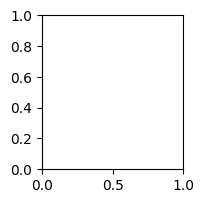

In [12]:
generate_figure(ref_imgs_male, src_imgs, fake_imgs_list['male'])

In [ ]:
generate_figure(ref_imgs_female, src_imgs, fake_imgs_list['female'])

Latent guided

In [ ]:
#source 
src_inputs = next(test_fetcher)
x_src, y_src = src_inputs.x, src_inputs.y

In [ ]:
#generate style from latent vector and trg domain
z = torch.randn(len(x_src),model_params.latent_dim).to(device)
y_trg = torch.logical_not(y_src).int() #trg domain chosen as opposite from src domain

style = nets.mapping_network(z,y_trg)

#generate source masks from FAN
masks=nets.fan.get_heatmap(x_src)

x_fake = nets.generator(x_src, style, masks)

In [ ]:
src_imgs = tensor_to_imgs(x_src)
fake_imgs = tensor_to_imgs(x_fake) 

In [ ]:
plt.figure(figsize=(4,6),dpi=400)
for i, (src_img, fake_img) in enumerate(zip(src_imgs, fake_imgs)):

    plt.subplot(len(src_imgs),2,2*i+1)
    if i==0 : plt.title("Source image")
    plt.imshow(src_img)
    plt.axis('off')

    plt.subplot(len(src_imgs),2,2*i+2)
    if i==0 : plt.title("Generated image")
    plt.imshow(fake_img)
    plt.axis('off')

plt.show()    

## AFHQ

In [4]:
#import celeba pretrained model
model_params = Munch({
    'img_size': 256, #256
    'latent_dim': 16,
    'style_dim': 64,
    'num_domains' : 3, #afhq
    'fan_pretrained_fname' : "architecture/FAN/weights.pth",
    "wFilter" : 0 # 0<= -> no FAN
})

nets, _ = Model(model_params) #instantiate model
cpt = torch.load("runs/afhq_model/000010__networs_copy.cpt") #take the copy weights -> moving average improves quality

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model_name, model in nets.items():
    print(model_name)
    if model_name in cpt:
        model.load_state_dict(cpt[model_name])
        model.eval().to(device)

generator
mapping_network
style_encoder
discriminator


In [5]:
#load dog, cat and wild datasets
root = "../shared/stargan_folder/data/afhq/val"
batch_size=6

#contains all domains' imgs. Returns corresponding label.
test_loader = get_loader(root, batch_size, model_params.img_size, chunk="test")
test_fetcher = Fetcher(test_loader,chunk="test")

dog_path=os.path.join(root,"dog")
dog_loader = get_loader(dog_path, batch_size//2, model_params.img_size, chunk="eval")
dog_fetcher = Fetcher(dog_loader, chunk="eval")

cat_path=os.path.join(root,"cat")
cat_loader = get_loader(cat_path, batch_size//2, model_params.img_size, chunk="eval")
cat_fetcher = Fetcher(cat_loader, chunk="eval")

wild_path=os.path.join(root,"wild")
wild_loader = get_loader(wild_path, batch_size//2, model_params.img_size, chunk="eval")
wild_fetcher = Fetcher(wild_loader, chunk="eval")

In [6]:
#source 
src_inputs = next(test_fetcher)
x_src, y_src = src_inputs.x, src_inputs.y

In [8]:
#random src to dog trg (ref)
#reference = target
x_ref_dog = next(dog_fetcher)
y_ref = torch.tensor([0]*len(x_ref_dog)).to(device)

#generate style from trg domain
style = nets.style_encoder(x_ref_dog, y_ref)
#copy the styles to apply to each src input
styles = (style.unsqueeze(1)).repeat(1,len(x_src),1) #add fake dimension at dim=1 and copy repeat every style N times to compatibility with src_dim

#generate reference guided output for every source to each reference
x_fakes_dog=[] #list of outputs from every reference
for style in styles:
    x_fake = nets.generator(x_src, style, None)
    x_fakes_dog.append(x_fake)

In [9]:
#random src to dog trg (ref)
#reference = target
x_ref_cat = next(cat_fetcher)
y_ref = torch.tensor([0]*len(x_ref_cat)).to(device)

#generate style from trg domain
style = nets.style_encoder(x_ref_cat, y_ref)
#copy the styles to apply to each src input
styles = (style.unsqueeze(1)).repeat(1,len(x_src),1) #add fake dimension at dim=1 and copy repeat every style N times to compatibility with src_dim

#generate reference guided output for every source to each reference
x_fakes_cat=[] #list of outputs from every reference
for style in styles:
    x_fake = nets.generator(x_src, style, None)
    x_fakes_cat.append(x_fake)

In [10]:
#random src to dog trg (ref)
#reference = target
x_ref_wild = next(wild_fetcher)
y_ref = torch.tensor([0]*len(x_ref_wild)).to(device)

#generate style from trg domain
style = nets.style_encoder(x_ref_wild, y_ref)
#copy the styles to apply to each src input
styles = (style.unsqueeze(1)).repeat(1,len(x_src),1) #add fake dimension at dim=1 and copy repeat every style N times to compatibility with src_dim

#generate reference guided output for every source to each reference
x_fakes_wild=[] #list of outputs from every reference
for style in styles:
    x_fake = nets.generator(x_src, style, None)
    x_fakes_wild.append(x_fake)

In [12]:
ref_imgs_dog = tensor_to_imgs(x_ref_dog)
ref_imgs_cat = tensor_to_imgs(x_ref_cat)
ref_imgs_wild = tensor_to_imgs(x_ref_wild)
src_imgs = tensor_to_imgs(x_src)
fake_imgs_list = {"dog" : [tensor_to_imgs(tensor) for tensor in x_fakes_dog],
                  "cat" : [tensor_to_imgs(tensor) for tensor in x_fakes_cat],
                  "wild" : [tensor_to_imgs(tensor) for tensor in x_fakes_wild]}#len(ref)xlen(src) -> 3x6
